# Parent - Child (all Gaussians)

## mean of Child is derived from the Parent Gaussian

the trick used here is that fitting the child data for only the mean and the scale and not the whole child data

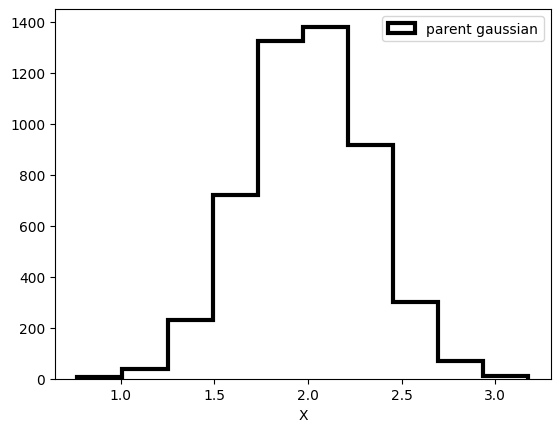

In [1]:
import numpy as np
import matplotlib.pyplot as plt

true_mean_parent = 2
true_scale_parent = 0.32
true_scale_child = 0.01
N_obs, size_child = 5000, 5

def gen_child_data(parent_data):
    return np.random.normal(loc=parent_data[:, np.newaxis], scale=true_scale_child, size=(N_obs, size_child))

def gen_parent_data(mu, sigma):
    return np.random.normal(loc=mu, scale=sigma, size=N_obs)

parent_data = gen_parent_data(true_mean_parent, true_scale_parent)
child_data = gen_child_data(parent_data)

#for i in range(N_obs):
#    plt.hist(child_data[i], fill=False, histtype='step')
plt.hist(parent_data, fill=False, histtype='step', color='black',linewidth=3, label='parent gaussian')
plt.xlabel("X")
plt.legend()

(array([   8.,   40.,  231.,  719., 1324., 1380.,  918.,  300.,   71.,
           9.]),
 array([0.76828074, 1.00907844, 1.24987614, 1.49067384, 1.73147154,
        1.97226924, 2.21306694, 2.45386464, 2.69466234, 2.93546004,
        3.17625774]),
 [<matplotlib.patches.Polygon at 0x7f6dde020940>])

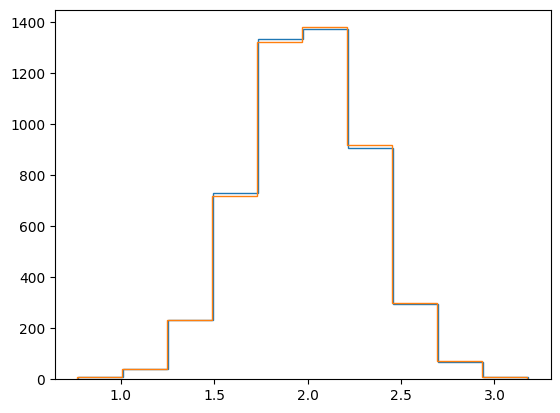

In [2]:
plt.hist(child_data.mean(axis=1),fill=False, histtype='step')
plt.hist(parent_data, fill=False, histtype='step')

In [3]:
def log_liklihood(param):
    parent_mu, parent_sigma = param # mu is fixed and so is sigma
    #model = gen_child_data(parent_data=gen_parent_data(parent_mu, parent_sigma))
    model = parent_sigma * np.random.randn(N_obs) + parent_mu
    return -0.5 * np.sum(np.log(2 * np.pi * true_scale_child**2) + (child_data.mean(axis=1) - model)**2 / true_scale_child**2)

def log_prior(param):
    parent_mu, parent_sigma = param
    if (true_mean_parent - 5 < parent_mu < true_mean_parent + 5 and 
        0.0 < parent_sigma < 1.0):
        return 0.0
    return -np.inf

def log_probability(param):
    lp = log_prior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_liklihood(param)

In [4]:
from scipy.optimize import minimize
np.random.seed(42)
nll = lambda *args: -log_liklihood(*args)
initial = np.array([true_mean_parent, true_scale_parent]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
parent_mu_ML, parent_sigma_ML = soln.x

print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(parent_mu_ML))
print("sigma = {0:.3f}".format(parent_sigma_ML))

Maximum likelihood estimates:
mu = 2.050
sigma = 0.306


In [5]:
import emcee

pos = soln.x + 1e-1 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

#from multiprocessing import Pool

#with Pool() as pool:
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability#, pool=pool
    )
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:32<00:00, 154.07it/s]


State([[2.00563541 0.01016612]
 [2.0030356  0.01280127]
 [2.00190401 0.01196545]
 [2.00231155 0.01318486]
 [2.00412646 0.01086376]
 [2.00265207 0.00983759]
 [2.00178053 0.01022989]
 [2.00179113 0.01058533]
 [2.00108487 0.01361383]
 [1.99958309 0.0196979 ]
 [2.00300218 0.00950531]
 [2.00590395 0.01954348]
 [2.00052147 0.01320119]
 [2.00233761 0.01490137]
 [1.99574092 0.01048084]
 [2.00125547 0.01425394]
 [2.00527297 0.01538404]
 [1.99888987 0.0160413 ]
 [2.00090335 0.00937465]
 [2.00535459 0.00884614]
 [2.00592081 0.01192   ]
 [2.00413876 0.0107631 ]
 [2.0050588  0.01422466]
 [1.99885225 0.01038111]
 [2.00219801 0.01181652]
 [1.99814687 0.00973419]
 [2.00251418 0.01170263]
 [2.0001252  0.01255973]
 [2.00255091 0.01014869]
 [2.00013045 0.01396789]
 [2.00253808 0.0146086 ]
 [1.99896235 0.01178844]
 [2.00323996 0.01382644]
 [2.00137132 0.00967817]
 [2.00242644 0.01119776]
 [2.00883945 0.01207516]
 [2.00221287 0.01098697]
 [2.00353109 0.00996448]
 [2.00428308 0.01503156]
 [2.00220409 0.0193

Text(0.5, 0, 'step number')

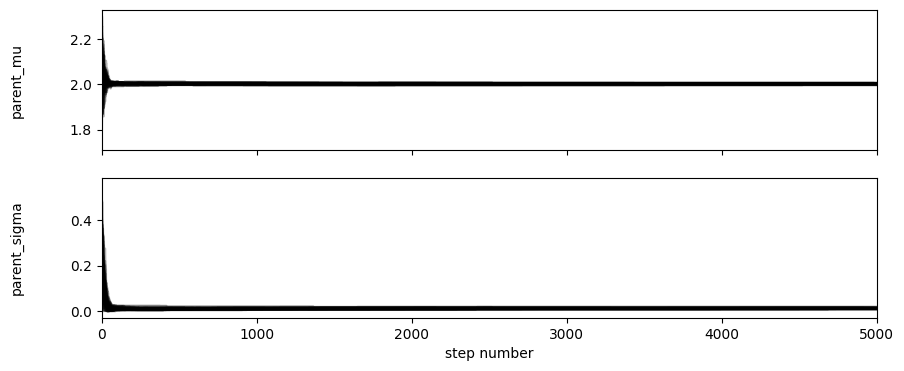

In [6]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["parent_mu", "parent_sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [7]:
tau = sampler.get_autocorr_time()
print(tau)

[85.74797818 38.87621083]


In [8]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 2)


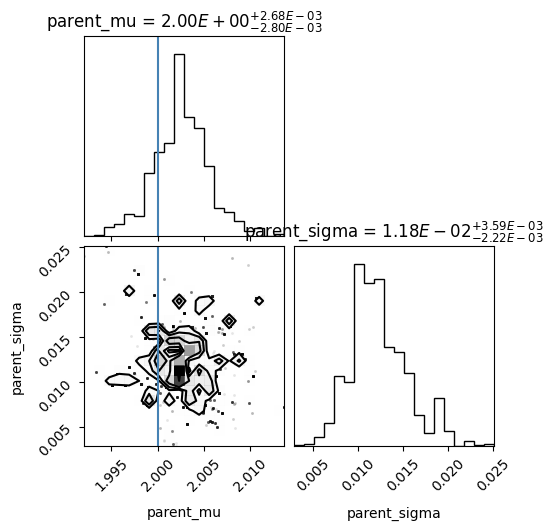

In [9]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_mean_parent, true_scale_parent], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)